In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils_xmatch import wsi_gaia_xmatch

Load in wsi and filter catalog

In [2]:
# read in wsi
wsi = pd.read_csv('data/wsi24.sb.prop.csv')
print(len(wsi))

# filter wsi
sample = wsi.loc[ wsi.wds_mag1 > 3 ].reset_index(drop=True)
# sample = sample.loc[ sample.wsi_sep > 0.8) ].reset_index(drop=True)
len(sample)

2874


2868

In [3]:
# export sample to query gaia
sample.to_csv('data/wsi.query_sample.csv', index=True, index_label='wsi_oid')

# Current setup
* 5 arcsec search radius
* queries gaia stars within 5 mags of match
* we propagate ALL secondaries

In [4]:
# load in data
wsi = pd.read_csv('data/wsi.query_sample.csv')
gaia_pri = pd.read_csv('data/pri-result.csv')
gaia_sec = pd.read_csv('data/sec-result.csv')

print( len(wsi) )
print( len(gaia_pri) )
print( len(gaia_sec) )

2868
4104
4033


In [5]:
# crossmatch with J2016 propagation
xmatch = wsi_gaia_xmatch( wsi, gaia_pri, gaia_sec )

# where did our crossmatch agree with simbad?
xmatch['sb_chk1'] = np.where( xmatch.gaia_id1 == xmatch.sb_id1, True, False )
xmatch['sb_chk2'] = np.where( xmatch.gaia_id2 == xmatch.sb_id2, True, False )

how many stars did we not find a match for?

In [6]:
print('no match candidates found in query')
print( 'primary:', list( xmatch.gaia_flag1 ).count('$') )
print( 'secondary:', list( xmatch.gaia_flag2 ).count('$') )

no match candidates found in query
primary: 29
secondary: 518


For only the secondaries with no proper motion, how many matches are missing?

In [7]:
print( 'With PM:', list( xmatch.loc[xmatch.wds_pm2 != '$'].gaia_flag2 ).count('$') )
print( 'Without PM:', list( xmatch.loc[xmatch.wds_pm2 == '$'].gaia_flag2 ).count('$') )

With PM: 308
Without PM: 210


### Comparison to simbad matches
Of the stars that simbad found a certain match for (no ! flag), what percentage did we match?

Need to split the primaries and the secondaries into 2 df for this.

In [8]:
# where simbad found pri match
sb1 = xmatch.loc[ xmatch.sb_flg1 == '.' ]
sb1_flg = xmatch.loc[ xmatch.sb_flg1 == '!' ]

# where simbad found sec match
sb2 = xmatch.loc[ xmatch.sb_flg2 == '.' ]
sb2_flg = xmatch.loc[ xmatch.sb_flg2 == '!' ]

print( 'direct |', 'pri:', len(sb1), 'sec:', len(sb2) )
print( 'flagged |', 'pri:', len(sb1_flg), 'sec:', len(sb2_flg) )

direct | pri: 2079 sec: 1636
flagged | pri: 19 sec: 10


In [9]:
# xmatch with targets we matched
xm = xmatch.loc[ (xmatch.gaia_flag1 != '$') & (xmatch.gaia_flag2 != '$') ]

# everything propagated using its own pm
pm = xm.loc[ xm.epoch_prop_flag != '!' ]

# sec propagated using primary
npm = xm.loc[ xm.epoch_prop_flag == '!' ]

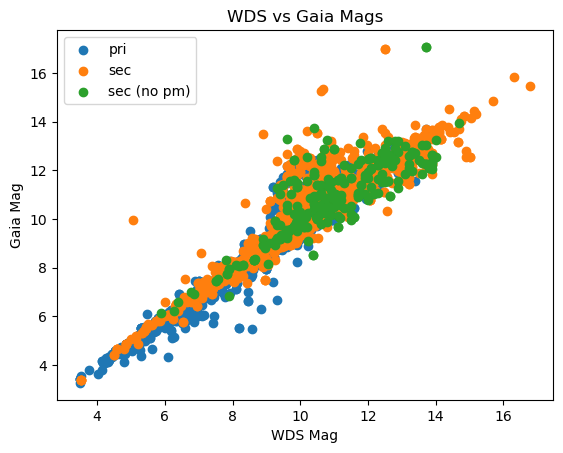

In [10]:
plt.scatter(xm.wds_mag1, xm.gaia_mag1, label='pri')
plt.scatter(pm.wds_mag2, pm.gaia_mag2, label='sec')
plt.scatter(npm.wds_mag2, npm.gaia_mag2, label='sec (no pm)')
plt.title('WDS vs Gaia Mags')
plt.xlabel('WDS Mag')
plt.ylabel('Gaia Mag')
plt.legend()
# plt.savefig('plots/wds_gaia_mag.png', dpi=300)
plt.show()

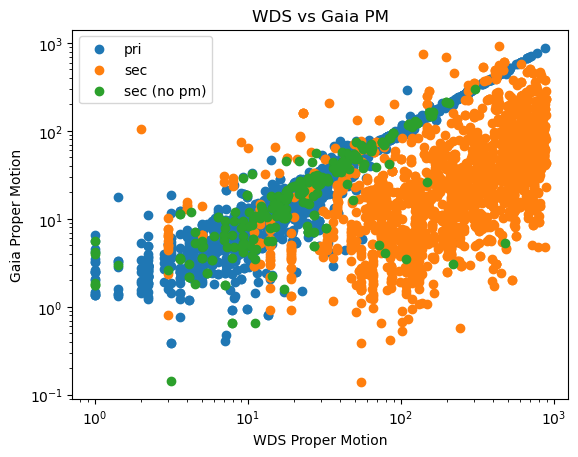

In [11]:
plt.scatter(xm.wds_pm1, xm.gaia_pm1, label='pri')
plt.scatter(pm.wds_pm2, pm.gaia_pm2, label='sec')
plt.scatter(npm.wds_pm1, npm.gaia_pm2, label='sec (no pm)')
plt.title('WDS vs Gaia PM')
plt.xlabel('WDS Proper Motion')
plt.ylabel('Gaia Proper Motion')
plt.legend()
plt.xscale('log')
plt.yscale('log')
# plt.savefig('plots/wds_gaia_pm.png', dpi=300)
plt.show()

Comparing to SIMBAD and histograms

In [12]:
print( sb1.sb_chk1.value_counts(True) )
print()
print( sb2.sb_chk2.value_counts(True) )

sb_chk1
True     0.950457
False    0.049543
Name: proportion, dtype: float64

sb_chk2
True     0.900978
False    0.099022
Name: proportion, dtype: float64


In [13]:
sb1T = sb1.loc[ sb1.sb_chk1==True ]
sb1F = sb1.loc[ sb1.sb_chk1==False ]
sb1T_flg = sb1_flg.loc[ sb1_flg.sb_chk1==True ]
sb1F_flg = sb1_flg.loc[ sb1_flg.sb_chk1==False ]

sb2T = sb2.loc[ sb2.sb_chk2==True ]
sb2F = sb2.loc[ sb2.sb_chk2==False ]
sb2T_flg = sb2_flg.loc[ sb2_flg.sb_chk2==True ]
sb2F_flg = sb2_flg.loc[ sb2_flg.sb_chk2==False ]

In [14]:
print( 'Primaries, SIMBAD Direct:' )
print( 'match:', len(sb1T), '|', 'no match:', len(sb1F) )
print()
print( 'Primaries, SIMBAD Flagged' )
print( 'match:', len(sb1T_flg), '|', 'no match:', len(sb1F_flg) )
print('============================')
print( 'Secondaries, SIMBAD Direct:' )
print( 'match:', len(sb2T), '|', 'no match:', len(sb2F) )
print()
print( 'Secondaries, SIMBAD Flagged' )
print( 'match:', len(sb2T_flg), '|', 'no match:', len(sb2F_flg) )

Primaries, SIMBAD Direct:
match: 1976 | no match: 103

Primaries, SIMBAD Flagged
match: 18 | no match: 1
Secondaries, SIMBAD Direct:
match: 1474 | no match: 162

Secondaries, SIMBAD Flagged
match: 2 | no match: 8


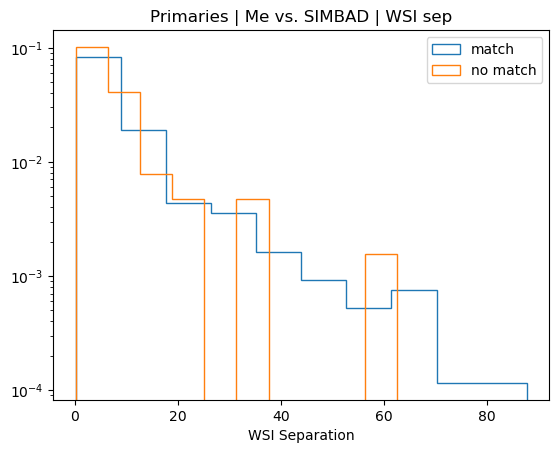

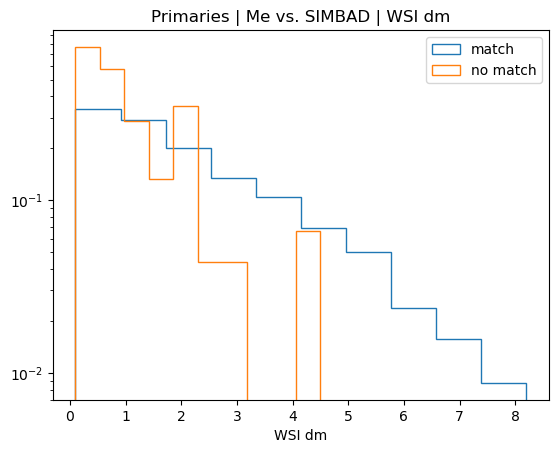

In [15]:
plt.hist(sb1T.wsi_sep, histtype='step', density=True, label='match')
plt.hist(sb1F.wsi_sep, histtype='step', density=True, label='no match')
plt.title('Primaries | Me vs. SIMBAD | WSI sep')
plt.yscale('log')
plt.xlabel('WSI Separation')
plt.legend()
plt.show()

plt.hist(sb1T.wsi_dm, histtype='step', density=True, label='match')
plt.hist(sb1F.wsi_dm, histtype='step', density=True, label='no match')
plt.title('Primaries | Me vs. SIMBAD | WSI dm')
plt.yscale('log')
plt.xlabel('WSI dm')
plt.legend()
plt.show()

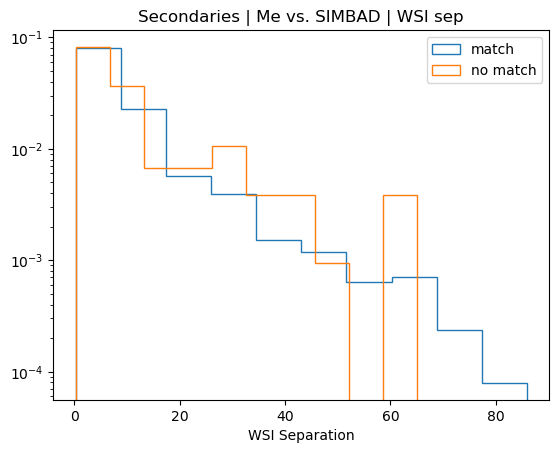

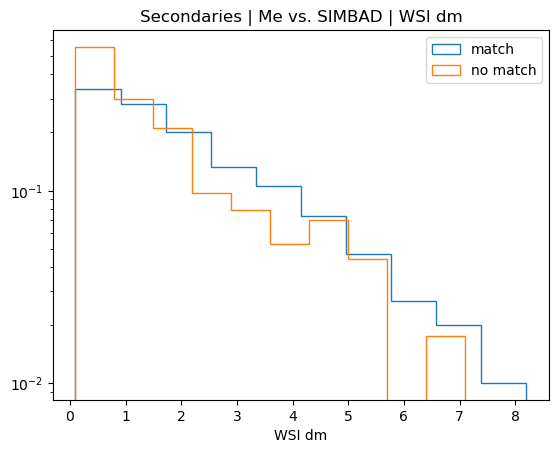

In [16]:
plt.hist(sb2T.wsi_sep, histtype='step', density=True, label='match')
plt.hist(sb2F.wsi_sep, histtype='step', density=True, label='no match')
plt.title('Secondaries | Me vs. SIMBAD | WSI sep')
plt.yscale('log')
plt.xlabel('WSI Separation')
plt.legend()
plt.show()

plt.hist(sb2T.wsi_dm, histtype='step', density=True, label='match')
plt.hist(sb2F.wsi_dm, histtype='step', density=True, label='no match')
plt.title('Secondaries | Me vs. SIMBAD | WSI dm')
plt.yscale('log')
plt.xlabel('WSI dm')
plt.legend()
plt.show()

Query gaia data from simbad matches to look at mag and pm plots

In [17]:
pri = xmatch.sb_id1.loc[ xmatch.sb_flg1=='.' ]
sec = xmatch.sb_id2.loc[ xmatch.sb_flg2=='.' ]

In [20]:
pri.to_csv('data/simbad_primaries.txt', index=False, header=False)
sec.to_csv('data/simbad_secondaries.txt', index=False, header=False)

In [23]:
# xmatch.to_csv('data/wsi24.xmatch.csv', index=False)